# Сравнение трудоёмкостей алгоритмов поисков на графах

* DFS - Depth-First Search - Поиск в глубину
* BFS - Breadth-First Search - Поиск в ширину

В качестве среды разработки используем интерактивные блокноты [Jupyter <base target="_blank">](https://jupyter.org/), а код написан на языке [Julia <base target="_blank">](https://julialang.org/).

---

### Отступление
Человек ленив. Там, где можно немного упростить себе жизнь, это будет сделано. С этой целью было создано множество высокоуровневых языков программирования, Julia - один из таких. В её экосистеме написано множество библиотек, где описываются графы и вводятся распространённые алгоритмы на них.

Человек ленив, а студент - тоже человек. Чем писать с нуля известные структуры (с риском ошибиться на ерунде), предлагаю сразу перейти к непосредственно поставленной задаче, доверившись, на этот раз, разработчикам используемых здесь библиотек.

### Что будем делать?

Генерация случайного графа оказалась нетривиальной задачей. Чтобы как-то ограничить исследование, предлагаю следующие шаги:
1. Чётко формализовать алгоритм генерации графа;
2. На каждом из них провести ряд вычислительных экспериментов с построением графиков зависимостей.

---

### Начинаем: импорт сторонних библиотек
В основном, графических, для визуального контроля

In [480]:
using Graphs
using GraphPlot
using NetworkLayout
using Colors
using Compose
using Plots
using PlotThemes
using Statistics
using GraphRecipes
using ProgressMeter;

### Теперь мы можем рисовать...
Начнём с простенького демонстрационного графа, который предоставляет сама библиотека 

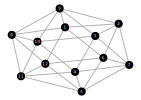

In [215]:
sample_12 = smallgraph(:icosahedral) # Здесь `:icosahedral` это значение-лейбл, служащее аргументом функции отрисовки

# Все аргументы рисовалки более-менее самообъясняющие:
gplot(   
    sample_12,
    nodefillc = "black",
    nodelabel = 1:nv(sample_12),
    nodelabelc = "white",
    edgestrokec = "darkgray",
)

Наряду со стандартным объявлением функции с помощью ключевого слова `function`, в Джулии в ходу сокращённая запись, более близкая к математической нотации. Сохраним понравившиеся настройки в виде новой функции одной переменной, в которую будем передавать только граф. В дальшейшем это облегчит синтаксические условности.

In [321]:
plot_graph(g; kwargs...) = 
    gplot(   
        g,
        nodefillc = "black",
        nodelabel = 1:nv(g),
        nodelabelc = "white",
        edgestrokec = "darkgray",
        arrowlengthfrac = 0.07,
        
    )

plot_graph (generic function with 1 method)

<!--

graphplot(   
    sample_12,
    curves = false,
    nodeshape = :circle,
    markercolor = :lightgrey,
    markersize = 0.2,
    names = 1:nv(sample_12), # `nv` возвращает количество вершин графа
    fontsize = 9,
)


plot_graph(g) = gplot(   
    g,
    nodefillc = "black",
    nodelabel = 1:nv(g),
    nodelabelc = "white",
    edgestrokec = "darkgray",
);

На примере графа из примера покажем, как будем считать трудоёмкость алгоритмов. В используемой библиотеке это делаем следующим образом:
1. У `sample_12` выберем вершину (у нас вершины имеют уникальные номера);
2. Начиная с неё нашего с вомощью соответствующих функций построим, соответственно, орграфы, основанные на интересующих нас алгоритмах обхода;
3. Найдём геодезические расстояния до всех вершин - они вернутся в виде массива;
4. По индексу найдём в массиве расстояние до интересующей нас вершины.

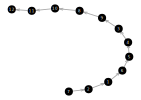

In [322]:
# Обход в глубину (начнём с 7-й вершины, почему бы и нет):
dfs_orgraph = dfs_tree(sample_12, 7)

plot_graph(dfs_orgraph)

In [218]:
# В массиве расстояний найдём по индексу расстояние до произвольного (другого) узла.
gdistances(dfs_orgraph, 7)[6] # До 6-го, например

3

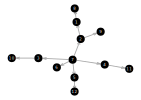

In [305]:
# Та же процедура с обходом в ширину:
bfs_orgraph = bfs_tree(sample_12, 7)

plot_graph(bfs_orgraph)

In [221]:
gdistances(bfs_orgraph, 7)[6]

1

Отлично, теперь мы готовы составить процедуру сравнения двух алгоритмов. Замечу, что если выбранная вершина принадлежит другой компоненте связности, то `gdistances` вернёт `Inf`

In [42]:
# Собирая описанное выше в единую функцию, возвращающую отношение расстояний
# Указание типов переменных опционально, но сделав это, мы упростим работу компилятору
function dfs_over_bfs(graph::SimpleGraph, node1::Int64, node2::Int64)::Float64
    @assert node1 != node2 "Ищем расстояние между разными узлами"
    dfs_dist = gdistances(dfs_tree(graph, node1), node1)[node2]
    bfs_dist = gdistances(bfs_tree(graph, node1), node1)[node2]
    return dfs_dist/bfs_dist # Эта не целочисленное, а обычное деление с float результатом
end;

Проверим работу функции на нашем икосаэдре:

In [44]:
@time dfs_over_bfs(sample_12, 7, 6)

  0.000034 seconds (121 allocations: 9.219 KiB)


3.0

Отлично, первый результат получен! Конечно, вероятнее всего, с точки зрения оптимизации, это не самый эффективный алгоритм. В нём подспудно происходит довольно много аллокаций (9.2Кб на моей машине), но в угоду простоте прототипирования мы опустим сейчас какие-либо оптимизации (хотя я не удержался и всё же аннотировал типы в нашей функции), хотя Julia позволяет их делать и может быть действительно эффективной, приближаясь по производительности к таким компилируемым языкам как C и Fortran. 

Теперь нам надо запустить эту функцию на каждой вершине, сравнивая ту со всеми остальными:

In [70]:
function dfs_over_bfs_average(graph::SimpleGraph)::Float64
    n_nodes = nv(graph)
    S = 0
    excluded = 0
    for i in 1:n_nodes
        Threads.@threads for j in i+1:n_nodes
            ratio = dfs_over_bfs(graph, i, j)
            if ratio == Inf
                excluded += 1 # Исключаем сравнения, узлов из разных компонент связности
            else
                S += ratio
            end
        end
    end
    return S / (n_nodes*(n_nodes-1) ÷ 2 - excluded)  # `÷` здесь - целочисленное деление
end;

In [74]:
@time dfs_over_bfs_average(sample_12)

  0.000483 seconds (7.78 k allocations: 596.484 KiB)


4.792929292929292

---

Перейдём, наконец, к объявленному вычислительному эксперименту. В пакете [Graphs.jl <base target="_blank">](https://juliagraphs.org/Graphs.jl/dev/) есть несколько алгоритмов генерации графов. Наперёд оценить, несколько один предпочтительнее другого не представляется возможным, так что попробуем несколько...

## Алгоритм генерации: [Dorogovtsev and Mendes <base target="_blank">](https://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/)
Вот как он описан в документации пакета:

>```
>dorogovtsev_mendes(n)
>```
>
>Generate a random `n` vertex graph by the Dorogovtsev-Mendes method (with `n ≥ 3`).
>
>The Dorogovtsev-Mendes process begins with a triangle graph and inserts `n-3` additional vertices. Each time a vertex is added, a random edge is selected and the new vertex is connected to the two endpoints of the chosen edge. This creates graphs with many triangles and a high local clustering coefficient.
>
>It is often useful to track the evolution of the graph as vertices are added, you can access the graph from the `t`-th stage of this algorithm by accessing the first `t` vertices with `g[1:t]`.
>
>### References
>
  >* http://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/
  >* https://arxiv.org/pdf/cond-mat/0106144.pdf#page=24

Как видим, этот генератор имеет вссего один параметр - количество узлов. Посмотрим, что он генерирует:

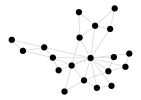

In [415]:
gplot(dorogovtsev_mendes(20), nodefillc = "black")

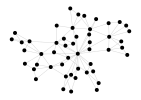

In [392]:
gplot(dorogovtsev_mendes(50), nodefillc = "black")

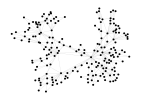

In [413]:
gplot(dorogovtsev_mendes(200), nodefillc = "black")

Замечу, что в сгенерированных графах (выше лишь несколько примеров) всегда есть вершины с относительно высокой степенью (назовём их "звёзды"). Похоже, они - естественное следствие работы генератора: чем больше рёбер смежно с вершиной, тем вероятнее, что при следующем шаге генератора, на одну из них выпадет стать смежной новой вершине, а значит, степень "звезды" снова повысится.

Так или иначе, приступаем к эксперименту. Сначала попробуем сравнить алгоритмы поиска для графов с разным количеством вершин:

In [427]:
function d_m_tests(n_max, repeats)
    results = Float32[]
    @showprogress for n = 5:n_max # Количество вершин
        av = 0
        for i = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(n) # новый случайный граф на каждом шаге
            av += dfs_over_bfs_average(g) # поиск всех путей - от каждой до каждой другой
        end
        push!(results, av/repeats)
    end
    return results
end

d_m_tests (generic function with 1 method)

In [449]:
dmt1 = d_m_tests(30, 10)
dmt2 = d_m_tests(30, 25)
dmt3 = d_m_tests(30, 50)
dmt4 = d_m_tests(30, 100)
dmt5 = d_m_tests(30, 200);
# Вычисления заняли 96 секунд на одном ядре процессора.

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:00

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Progress:  42%|█████████████████▍                       |  ETA: 0:00:00

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:00

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:00

Progress:  73%|██████████████████████████████           |  ETA: 0:00:00

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:00

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:00

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:00

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:00

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:00

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Progress:  27%|███████████                              |  ETA: 0:00:00

Progress:  46%|██████████████████▉                      |  ETA: 0:00:01

Progress:  50%|████████████████████▌                    |  ETA: 0:00:01

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:01

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:01

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:01

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:01

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:01

Progress:  73%|██████████████████████████████           |  ETA: 0:00:01

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:01

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:01

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:01

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:01

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


Progress:  12%|████▊                                    |  ETA: 0:00:01

Progress:  19%|███████▉                                 |  ETA: 0:00:02

Progress:  23%|█████████▌                               |  ETA: 0:00:02

Progress:  27%|███████████                              |  ETA: 0:00:02

Progress:  31%|████████████▋                            |  ETA: 0:00:03

Progress:  35%|██████████████▎                          |  ETA: 0:00:03

Progress:  38%|███████████████▊                         |  ETA: 0:00:03

Progress:  42%|█████████████████▍                       |  ETA: 0:00:03

Progress:  46%|██████████████████▉                      |  ETA: 0:00:03

Progress:  50%|████████████████████▌                    |  ETA: 0:00:03

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:03

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:04

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:04

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:04

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:04

Progress:  73%|██████████████████████████████           |  ETA: 0:00:04

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:04

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:04

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:03

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:02

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Progress:   8%|███▏                                     |  ETA: 0:00:01

Progress:  15%|██████▎                                  |  ETA: 0:00:02

Progress:  19%|███████▉                                 |  ETA: 0:00:02

Progress:  23%|█████████▌                               |  ETA: 0:00:03

Progress:  27%|███████████                              |  ETA: 0:00:03

Progress:  31%|████████████▋                            |  ETA: 0:00:03

Progress:  35%|██████████████▎                          |  ETA: 0:00:04

Progress:  38%|███████████████▊                         |  ETA: 0:00:05

Progress:  42%|█████████████████▍                       |  ETA: 0:00:05

Progress:  46%|██████████████████▉                      |  ETA: 0:00:05

Progress:  50%|████████████████████▌                    |  ETA: 0:00:06

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:06

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:07

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:07

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:07

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:07

Progress:  73%|██████████████████████████████           |  ETA: 0:00:08

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:07

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:06

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:05

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:04

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


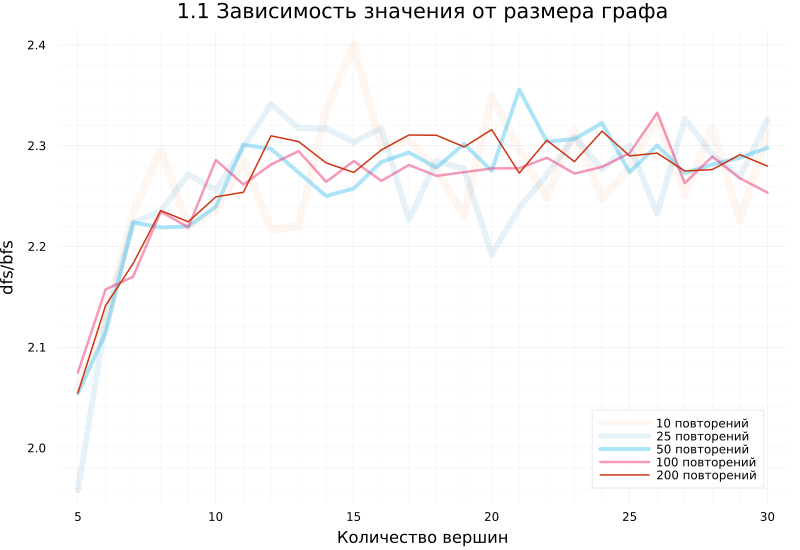

In [525]:
theme(:vibrant)
plot(5:30, dmt1,
    title = "1.1 Зависимость значения от размера графа",
    legend = :bottomright,
    label = "10 повторений",
    size = (800, 550),
    xaxis = "Количество вершин",
    yaxis = "dfs/bfs",
    linewidth =8,
    alpha = 0.07,
    )
plot!(5:30, dmt2, label = "25 повторений",linewidth =6, alpha = 0.1,)
plot!(5:30, dmt3, label = "50 повторений",linewidth =4, alpha = 0.4,)
plot!(5:30, dmt4, label = "100 повторений",linewidth = 2.5,  alpha = 0.5,)
plot!(5:30, dmt5, label = "200 повторений",linewidth = 1.5, alpha = 1,)

In [487]:
savefig("plots/1.1.svg")

"/home/alex/Documents/Git/Lab/julia_stuff/Trees/plots/1.1.svg"

#### Вывод первый - слишком много усреднений делать не нужно.
Тренд прослеживается, а ждать долго. Тем более, с ростом количества вершин сложность выполнения `d_m_tests`, и так по ощущениям, растёт куда как круче, чем **O(n²)** или **O(n³)**. Не будем добавлять к этому дополнительный множитель.

In [ ]:
dmt6 = d_m_tests(100, 50);
# Посчиталось за 23м 24сек на 1 ядре.

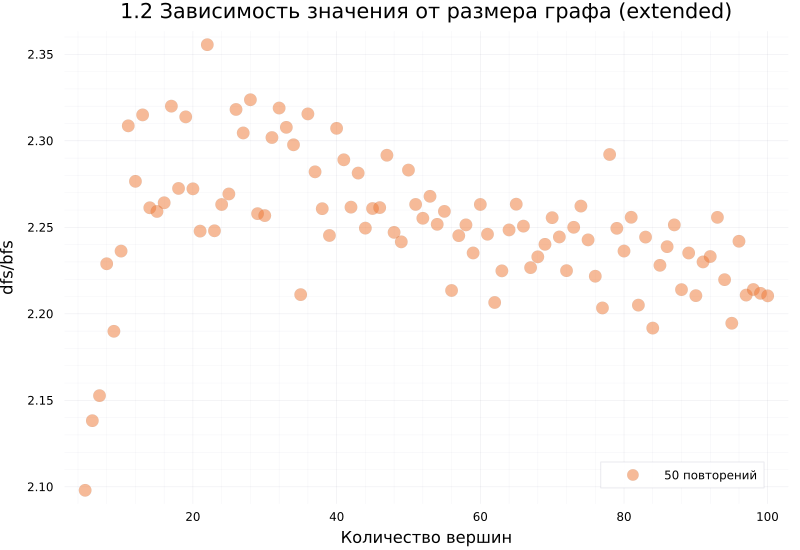

In [497]:
theme(:vibrant)
scatter(5:100, dmt6,
    title = "1.2 Зависимость значения от размера графа (extended)",
    legend = :bottomright,
    label = "50 повторений",
    size = (800, 550),
    xaxis = "Количество вершин",
    yaxis = "dfs/bfs",
    markersize =7,
    alpha = 0.5,
    )

In [492]:
savefig("plots/1.2.svg")

"/home/alex/Documents/Git/Lab/julia_stuff/Trees/plots/1.2.svg"

#### Вывод второй - всё интересное начинается за границей графика.
Более чем 20-минутное ожидание того стоило. После 30 вершин график, вне всяких сомнений, начал снижение. Продолжаем исследования.